## Image Captioning with RNNs

In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import matplotlib.pyplot as plt

from cs231n.rnn_layers import * 
from cs231n.image_utils import image_from_url
from cs231n.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from cs231n.coco_utils import load_coco_data, decode_captions, sample_coco_minibatch

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

### Microsoft COCO

In [2]:
# Load COCO data from disk; this returns a dictionary
# We'll work with dimensionality-reduced features for this notebook, but feel free to experiment with the 
# original features by changing the flag below.
data = load_coco_data(pca_features = True)

# Print out all the keys and the values from the data dictionary
for k, v in data.items():
    if type(v) == np.ndarray:
        print(k, type(v), v.shape, v.dtype)
    else:
        print(k, type(v), len(v))

idx_to_word <class 'list'> 1004
val_captions <class 'numpy.ndarray'> (195954, 17) int32
val_image_idxs <class 'numpy.ndarray'> (195954,) int32
train_features <class 'numpy.ndarray'> (82783, 512) float32
train_urls <class 'numpy.ndarray'> (82783,) <U63
val_features <class 'numpy.ndarray'> (40504, 512) float32
val_urls <class 'numpy.ndarray'> (40504,) <U63
word_to_idx <class 'dict'> 1004
train_captions <class 'numpy.ndarray'> (400135, 17) int32
train_image_idxs <class 'numpy.ndarray'> (400135,) int32


### Look at the data

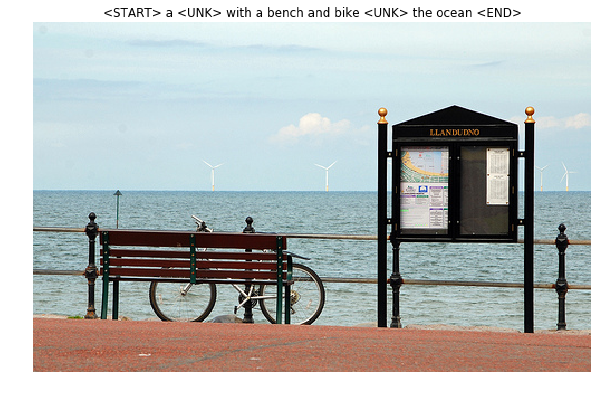

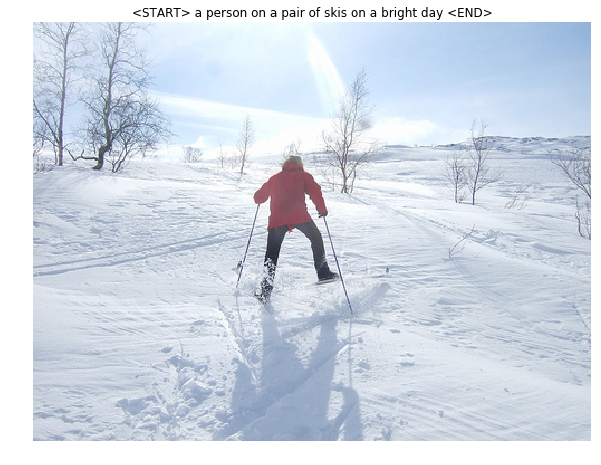

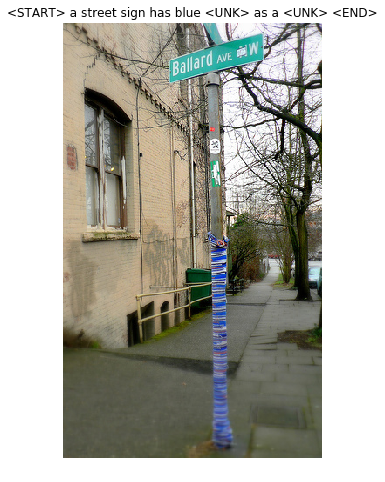

In [3]:
# Sample a minibatch and show the images and captions
batch_size = 3

captions, features, urls = sample_coco_minibatch(data, batch_size = batch_size)
for i, (caption, url) in enumerate(zip(captions, urls)):
    plt.imshow(image_from_url(url))
    plt.axis('off')
    caption_str = decode_captions(caption, data['idx_to_word'])
    plt.title(caption_str)
    plt.show()

## Recurrent Neural Networks

### Vanilla RNN: step forward

In [4]:
from cs231n.rnn_layers import rnn_step_forward

N, D, H = 3, 10, 4
x = np.linspace(-0.4, 0.7, num=N*D).reshape(N, D)
prev_h = np.linspace(-0.2, 0.5, num=N*H).reshape(N, H)
Wx = np.linspace(-0.1, 0.9, num=D*H).reshape(D, H)
Wh = np.linspace(-0.3, 0.7, num=H*H).reshape(H, H)
b = np.linspace(-0.2, 0.4, num=H)

next_h, _ = rnn_step_forward(x, prev_h, Wx, Wh, b)
expected_next_h = np.asarray([
  [-0.58172089, -0.50182032, -0.41232771, -0.31410098],
  [ 0.66854692,  0.79562378,  0.87755553,  0.92795967],
  [ 0.97934501,  0.99144213,  0.99646691,  0.99854353]])

print('next_h error: ', rel_error(expected_next_h, next_h))

next_h error:  6.29242142647e-09


### Vanilla RNN: step backward

In [5]:
from cs231n.rnn_layers import rnn_step_forward, rnn_step_backward

N, D, H = 4, 5, 6
x = np.random.randn(N, D)
h = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_step_forward(x, h, Wx, Wh, b)

dnext_h = np.random.randn(*out.shape)

fx = lambda x: rnn_step_forward(x, h, Wx, Wh, b)[0]
fh = lambda prev_h: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_step_forward(x, h, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_step_forward(x, h, Wx, Wh, b)[0]
fb = lambda b: rnn_step_forward(x, h, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dnext_h)
dprev_h_num = eval_numerical_gradient_array(fh, h, dnext_h)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dnext_h)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dnext_h)
db_num = eval_numerical_gradient_array(fb, b, dnext_h)

dx, dprev_h, dWx, dWh, db = rnn_step_backward(dnext_h, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dprev_h error: ', rel_error(dprev_h_num, dprev_h))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  5.52178391952e-10
dprev_h error:  3.1833438098e-10
dWx error:  1.25965451298e-08
dWh error:  3.2130342494e-10
db error:  5.24035719802e-11


### Vanilla RNN: forward

In [6]:
from cs231n.rnn_layers import *

N, T, D, H = 2, 3, 4, 5

x = np.linspace(-0.1, 0.3, num = N * T * D).reshape(N, T, D)
h0 = np.linspace(-0.3, 0.1, num = N * H).reshape(N, H)
Wx = np.linspace(-0.2, 0.4, num = D * H).reshape(D, H)
Wh = np.linspace(-0.4, 0.1, num = H * H).reshape(H, H)
b = np.linspace(-0.7, 0.1, num = H)

h, _ = rnn_forward(x, h0, Wx, Wh, b)
expected_h = np.asarray([
  [
    [-0.42070749, -0.27279261, -0.11074945,  0.05740409,  0.22236251],
    [-0.39525808, -0.22554661, -0.0409454,   0.14649412,  0.32397316],
    [-0.42305111, -0.24223728, -0.04287027,  0.15997045,  0.35014525],
  ],
  [
    [-0.55857474, -0.39065825, -0.19198182,  0.02378408,  0.23735671],
    [-0.27150199, -0.07088804,  0.13562939,  0.33099728,  0.50158768],
    [-0.51014825, -0.30524429, -0.06755202,  0.17806392,  0.40333043]]])
print('h error: ', rel_error(expected_h, h))

h error:  7.72846615831e-08


### Vanilla RNN: backward

In [7]:
from cs231n.rnn_layers import *

N, D, T, H = 2, 3, 10, 5
x = np.random.randn(N, T, D)
h0 = np.random.randn(N, H)
Wx = np.random.randn(D, H)
Wh = np.random.randn(H, H)
b = np.random.randn(H)

out, cache = rnn_forward(x, h0, Wx, Wh, b)

dout = np.random.randn(*out.shape)

dx, dh0, dWx, dWh, db = rnn_backward(dout, cache)

fx = lambda x: rnn_forward(x, h0, Wx, Wh, b)[0]
fh0 = lambda h0: rnn_forward(x, h0, Wx, Wh, b)[0]
fWx = lambda Wx: rnn_forward(x, h0, Wx, Wh, b)[0]
fWh = lambda Wh: rnn_forward(x, h0, Wx, Wh, b)[0]
fb = lambda b: rnn_forward(x, h0, Wx, Wh, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dh0_num = eval_numerical_gradient_array(fh0, h0, dout)
dWx_num = eval_numerical_gradient_array(fWx, Wx, dout)
dWh_num = eval_numerical_gradient_array(fWh, Wh, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

print('dx error: ', rel_error(dx_num, dx))
print('dh0 error: ', rel_error(dh0_num, dh0))
print('dWx error: ', rel_error(dWx_num, dWx))
print('dWh error: ', rel_error(dWh_num, dWh))
print('db error: ', rel_error(db_num, db))

dx error:  1.76221972672e-08
dh0 error:  2.72384723696e-10
dWx error:  1.0398121562e-09
dWh error:  1.09258997112e-09
db error:  1.73450695998e-09


### Word embedding: forward

In [8]:
from cs231n.rnn_layers import *

N, T, V, D = 2, 4, 5, 3

x = np.asarray([[0, 3, 1, 2], [2, 1, 0, 3]])
W = np.linspace(0, 1, num=V * D).reshape(V, D)

out, _ = word_embedding_forward(x, W)
expected_out = np.asarray([
 [[ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.42857143,  0.5,         0.57142857]],
 [[ 0.42857143,  0.5,         0.57142857],
  [ 0.21428571,  0.28571429,  0.35714286],
  [ 0.,          0.07142857,  0.14285714],
  [ 0.64285714,  0.71428571,  0.78571429]]])

print('out error: ', rel_error(expected_out, out))

out error:  1.00000000947e-08


### Word embedding: backward

In [9]:
from cs231n.rnn_layers import *

N, T, V, D = 50, 3, 5, 6
x = np.random.randint(V, size=(N, T))
W = np.random.randn(V, D)

out, cache = word_embedding_forward(x, W)
dout = np.random.randn(*out.shape)
dW = word_embedding_backward(dout, cache)

f = lambda W: word_embedding_forward(x, W)[0]
dW_num = eval_numerical_gradient_array(f, W, dout)

print('dW error: ', rel_error(dW, dW_num))

dW error:  3.27678838261e-12


### Temporal Affine layer

In [10]:
from cs231n.rnn_layers import *

# Gradient check for temporal affine layer
N, T, D, M = 2, 3, 4, 5

x = np.random.randn(N, T, D)
w = np.random.randn(D, M)
b = np.random.randn(M)

out, cache = temporal_affine_forward(x, w, b)

dout = np.random.randn(*out.shape)

fx = lambda x: temporal_affine_forward(x, w, b)[0]
fw = lambda w: temporal_affine_forward(x, w, b)[0]
fb = lambda b: temporal_affine_forward(x, w, b)[0]

dx_num = eval_numerical_gradient_array(fx, x, dout)
dw_num = eval_numerical_gradient_array(fw, w, dout)
db_num = eval_numerical_gradient_array(fb, b, dout)

dx, dw, db = temporal_affine_backward(dout, cache)

print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

dx error:  1.18464635454e-09
dw error:  3.65924812074e-11
db error:  8.61279065635e-12


### Temporal Softmax loss

In [11]:
from cs231n.rnn_layers import *

# Sanity check for temporal softmax loss
N, T, V = 100, 1, 10

def check_loss(N, T, V, p):
    x = 0.001 * np.random.randn(N, T, V)
    y = np.random.randint(V, size=(N, T))
    mask = np.random.rand(N, T) <= p
    print(temporal_softmax_loss(x, y, mask)[0])

check_loss(100, 1, 10, 1.0)   # Should be about 2.3
check_loss(100, 10, 10, 1.0)  # Should be about 23
check_loss(5000, 10, 10, 0.1) # Should be about 2.3

# Gradient check for temporal softmax loss
N, T, V = 7, 8, 9

x = np.random.randn(N, T, V)
y = np.random.randint(V, size=(N, T))
mask = (np.random.rand(N, T) > 0.5)

loss, dx = temporal_softmax_loss(x, y, mask, verbose=False)

dx_num = eval_numerical_gradient(lambda x: temporal_softmax_loss(x, y, mask)[0], x, verbose=False)

print('dx error: ', rel_error(dx, dx_num))

2.30260730084
23.025434146
2.25609274957
dx error:  6.26294911095e-08


### RNN for image captioning

In [12]:
from cs231n.rnn_layers import * 
from cs231n.classifiers.rnn import * 

N, D, W, H = 10, 20, 30, 40
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
V = len(word_to_idx)
T = 13

model = CaptioningRNN(word_to_idx,
          input_dim=D,
          wordvec_dim=W,
          hidden_dim=H,
          cell_type='rnn',
          dtype=np.float64)

# Set all model parameters to fixed values
for k, v in model.params.items():
    model.params[k] = np.linspace(-1.4, 1.3, num=v.size).reshape(*v.shape)

features = np.linspace(-1.5, 0.3, num=(N * D)).reshape(N, D)
captions = (np.arange(N * T) % V).reshape(N, T)

loss, grads = model.loss(features, captions)
expected_loss = 9.83235591003

print('loss: ', loss)
print('expected loss: ', expected_loss)
print('difference: ', abs(loss - expected_loss))

loss:  9.83235591003
expected loss:  9.83235591003
difference:  2.61302091076e-12


In [13]:
batch_size = 2
timesteps = 3
input_dim = 4
wordvec_dim = 5
hidden_dim = 6
word_to_idx = {'<NULL>': 0, 'cat': 2, 'dog': 3}
vocab_size = len(word_to_idx)

captions = np.random.randint(vocab_size, size=(batch_size, timesteps))
features = np.random.randn(batch_size, input_dim)

model = CaptioningRNN(word_to_idx,
          input_dim=input_dim,
          wordvec_dim=wordvec_dim,
          hidden_dim=hidden_dim,
          cell_type='rnn',
          dtype=np.float64,
        )

loss, grads = model.loss(features, captions)

for param_name in sorted(grads):
    f = lambda _: model.loss(features, captions)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s relative error: %e' % (param_name, e))

W_embed relative error: 9.405292e-09
W_proj relative error: 7.417844e-09
W_vocab relative error: 4.580755e-09
Wh relative error: 2.738075e-09
Wx relative error: 1.045760e-06
b relative error: 3.979916e-10
b_proj relative error: 5.627718e-09
b_vocab relative error: 2.729908e-10


### Overfit small data

(Iteration 1 / 100) loss: 77.494246
(Iteration 11 / 100) loss: 27.287253
(Iteration 21 / 100) loss: 3.953269
(Iteration 31 / 100) loss: 0.807594
(Iteration 41 / 100) loss: 0.344536
(Iteration 51 / 100) loss: 0.163925
(Iteration 61 / 100) loss: 0.130354
(Iteration 71 / 100) loss: 0.105241
(Iteration 81 / 100) loss: 0.082356
(Iteration 91 / 100) loss: 0.102205


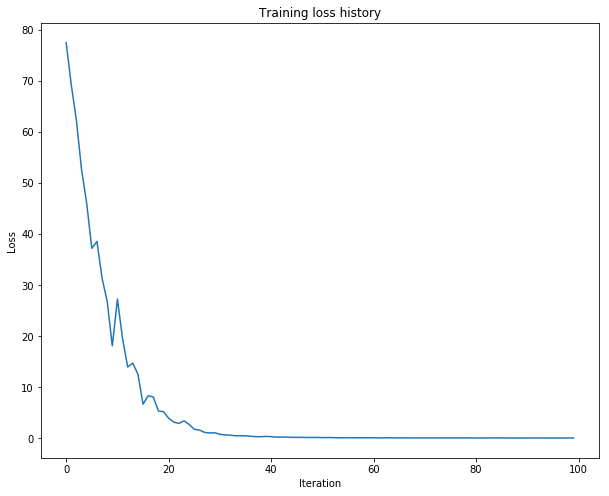

In [14]:
from cs231n.rnn_layers import *
from cs231n.captioning_solver import * 

small_data = load_coco_data(max_train=50)

small_rnn_model = CaptioningRNN(
          cell_type = 'rnn',
          word_to_idx = data['word_to_idx'],
          input_dim = data['train_features'].shape[1],
          hidden_dim= 512,
          wordvec_dim = 256,
        )

small_rnn_solver = CaptioningSolver(small_rnn_model, small_data,
           update_rule = 'adam',
           num_epochs = 50,
           batch_size = 25,
           optim_config = {
             'learning_rate': 5e-3,
           },
           lr_decay = 0.95,
           verbose = True, print_every = 10,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

### Test-time sampling

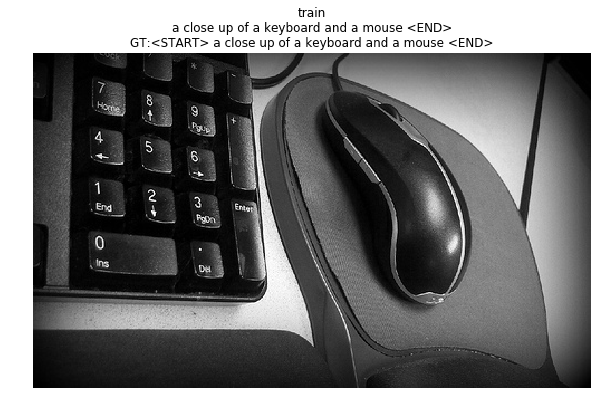

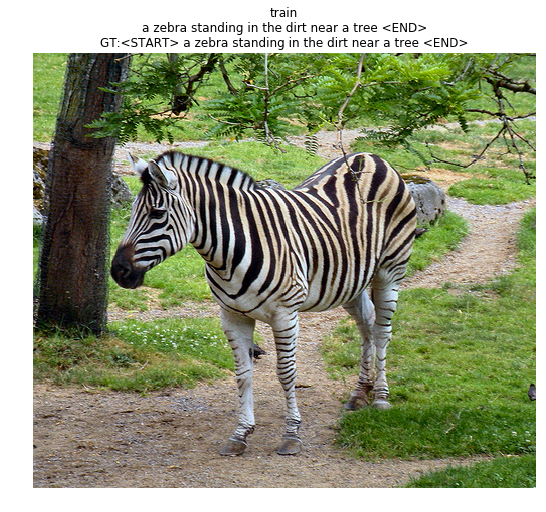

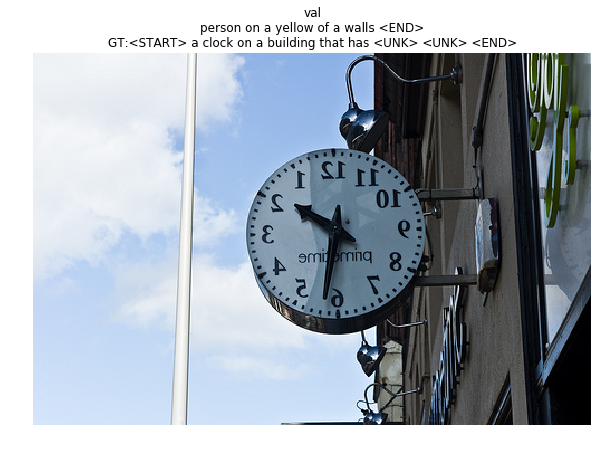

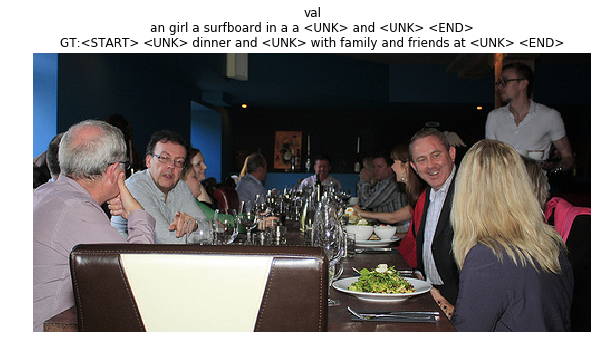

In [15]:
from cs231n.rnn_layers import *

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(small_data, split=split, batch_size=2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])
    
    sample_captions = small_rnn_model.sample(features)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])
    
    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()

### Train a model

(Iteration 1 / 100) loss: 0.073109
(Iteration 11 / 100) loss: 0.077182
(Iteration 21 / 100) loss: 0.073137
(Iteration 31 / 100) loss: 0.071981
(Iteration 41 / 100) loss: 0.074467
(Iteration 51 / 100) loss: 0.074466
(Iteration 61 / 100) loss: 0.071911
(Iteration 71 / 100) loss: 0.062956
(Iteration 81 / 100) loss: 0.064922
(Iteration 91 / 100) loss: 0.067570


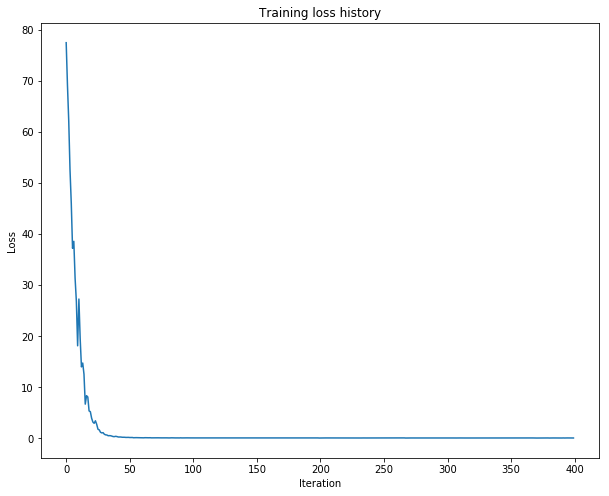

In [21]:
from cs231n.rnn_layers import *
from cs231n.captioning_solver import * 

data = load_coco_data(max_train = 10000)

rnn_model = CaptioningRNN(
          cell_type = 'rnn',
          word_to_idx = data['word_to_idx'],
          input_dim = data['train_features'].shape[1],
          hidden_dim= 4096,
          wordvec_dim = 512,
        )

rnn_solver = CaptioningSolver(rnn_model, data,
           update_rule = 'adam',
           num_epochs = 10,
           batch_size = 256,
           optim_config = {
             'learning_rate': 5e-3,
           },
           lr_decay = 0.95,
           verbose = True, print_every = 100,
         )

small_rnn_solver.train()

# Plot the training losses
plt.plot(small_rnn_solver.loss_history)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

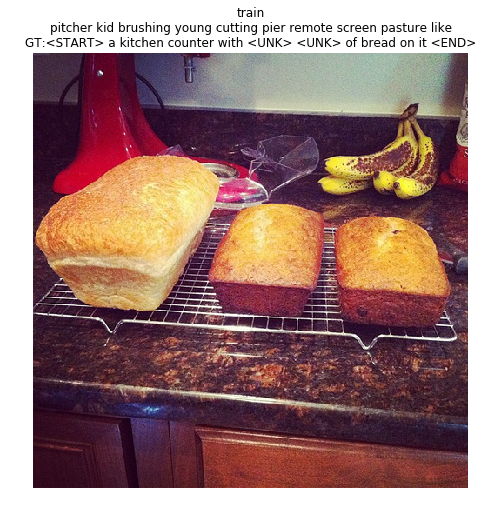

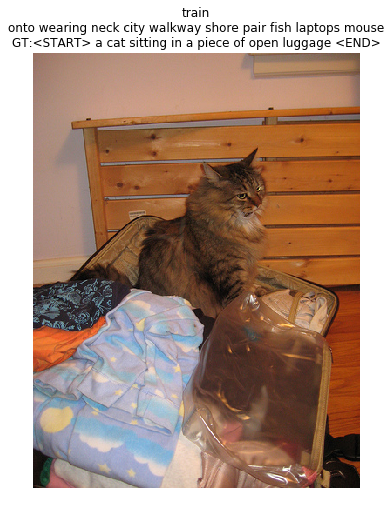

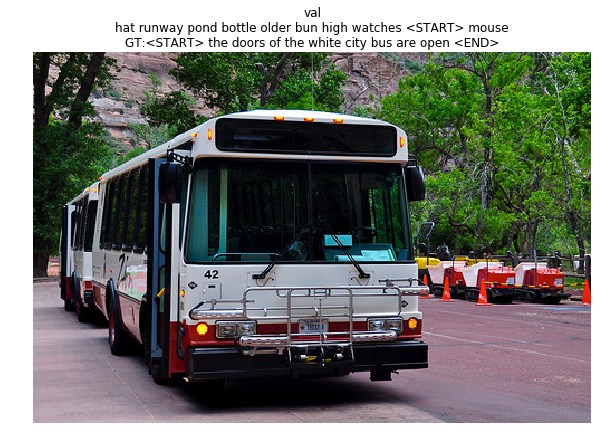

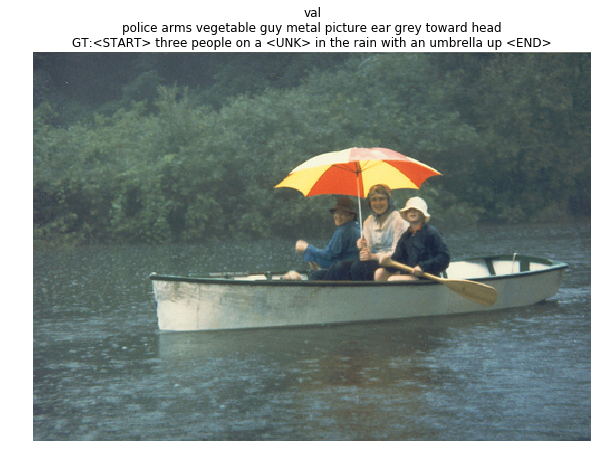

In [23]:
from cs231n.rnn_layers import *

for split in ['train', 'val']:
    minibatch = sample_coco_minibatch(data, split = split, batch_size = 2)
    gt_captions, features, urls = minibatch
    gt_captions = decode_captions(gt_captions, data['idx_to_word'])
    
    sample_captions = rnn_model.sample(features, max_length = 10)
    sample_captions = decode_captions(sample_captions, data['idx_to_word'])
    
    for gt_caption, sample_caption, url in zip(gt_captions, sample_captions, urls):
        plt.imshow(image_from_url(url))
        plt.title('%s\n%s\nGT:%s' % (split, sample_caption, gt_caption))
        plt.axis('off')
        plt.show()